# Feature visualization

Let's experiment with visualising some of the features in the neural network.

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CellPredictorNeuralNetwork(nn.Module):
    """Predicts the next state of the cells.

    Inputs:
        x: Tensor of shape (batch_size, channels, width+2, height+2), where channels=1. width and height are the dimensions of the entire game grid.
           We add one cell of padding on each side to ensure that predictions can be made for the boundary cells.
    
    Returns: Tensor of shape (batch_size, width, height), the logits of the predicted states.
    """

    def __init__(self):
        super().__init__()
        self.conv0 = nn.Conv2d(1, 85, 3)
        self.conv1 = nn.Conv2d(85, 10, 1)
        self.conv2 = nn.Conv2d(10, 1, 1)

    def forward(self, x):
        x = F.relu(self.conv0(x))
        x = F.relu(self.conv1(x))
        logits = self.conv2(x)
        logits = torch.squeeze(logits, 1) # Remove channels dimension
        return logits

In [77]:
model = CellPredictorNeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth"))

<All keys matched successfully>

## `conv0` layer

Since the `conv0` layer is just a 3 x 3 2D convolution and takes its input straight from the input data, we can visualise the layers as 3 x 3 grids. The values in the grid are just the weights, ignoring the bias, because that's what we would obtain if we did gradient ascent on the input space. (This is due to the Cauchy-Schwarz inequality).

In [8]:
print(model.conv0.weight.shape)
print(model.conv0.bias.shape)

torch.Size([85, 1, 3, 3])
torch.Size([85])


[[0.8724248  0.         0.950449  ]
 [0.07223934 0.74881715 0.06117183]
 [0.38132328 0.5775547  0.3574369 ]]


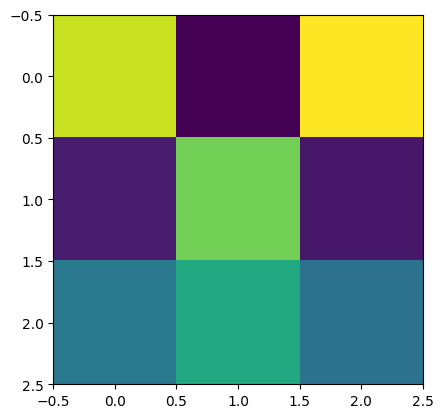

In [82]:
# Visualize a single feature

feature = 0

with torch.no_grad():
    feature_viz = model.conv0.weight[feature, 0, :, :]
    feature_viz = feature_viz.numpy().copy() # For some reason we need this to avoid overwriting the model weights
feature_viz /= np.max(np.abs(feature_viz)) # Scale to [-1, 1]
feature_viz -= np.min(feature_viz) # Shift to [0, 2]
feature_viz /= 2.0 # Scale to [0, 1]
print(feature_viz)

plt.imshow(feature_viz, interpolation="nearest")

In [87]:
# Visualize multiple features

with torch.no_grad():
    feature_viz = model.conv0.weight[:, 0, :, :]
    feature_viz = feature_viz.numpy().copy()
feature_viz /= np.abs(feature_viz).max(axis=(1, 2), keepdims=True) # Scale to [-1, 1]
feature_viz -= np.min(feature_viz, axis=(1,2), keepdims=True) # Shift to [0, 2]
feature_viz /= 2.0 # Scale to [0, 1]


def plot_features(i):
    fig, axs = plt.subplots(3, 6, constrained_layout=True, figsize=(10, 5))
    axs = axs.flatten()

    for j in range(18):
        feature = 18*i + j
        ax: plt.Axes = axs[j]

        if feature >= 85:
            ax.set_visible(False)
            continue

        ax.imshow(feature_viz[feature], interpolation="nearest",)
        ax.set_title(f"Feature {feature}")

    plt.show()

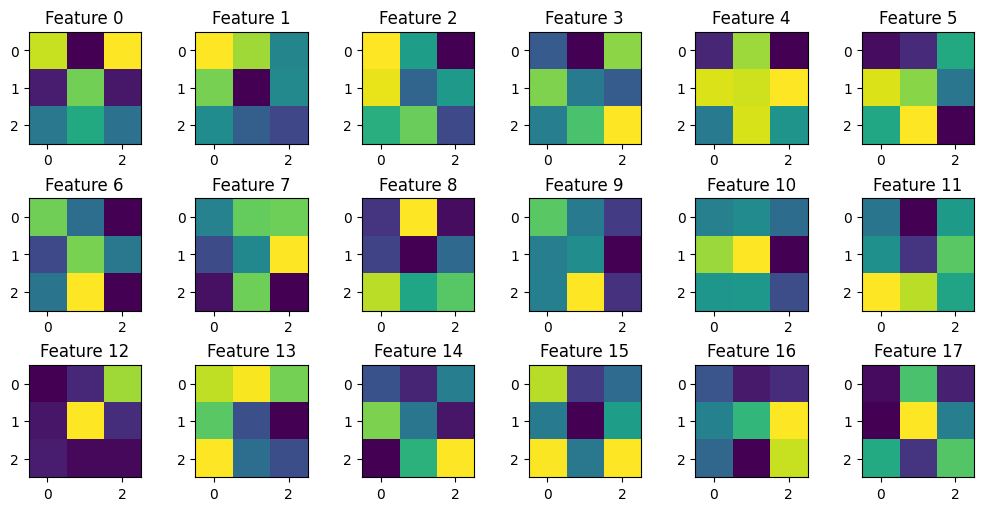

In [90]:
plot_features(0)

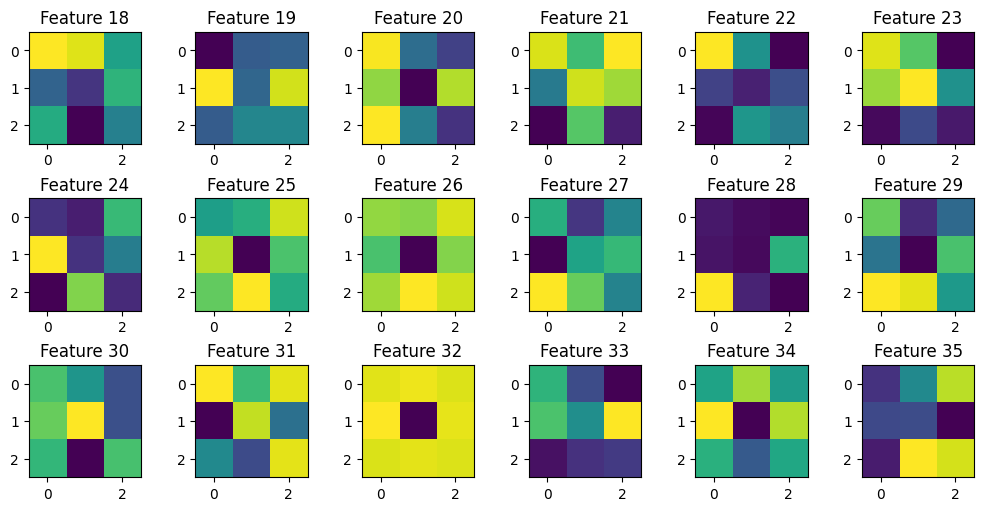

In [58]:
plot_features(1)

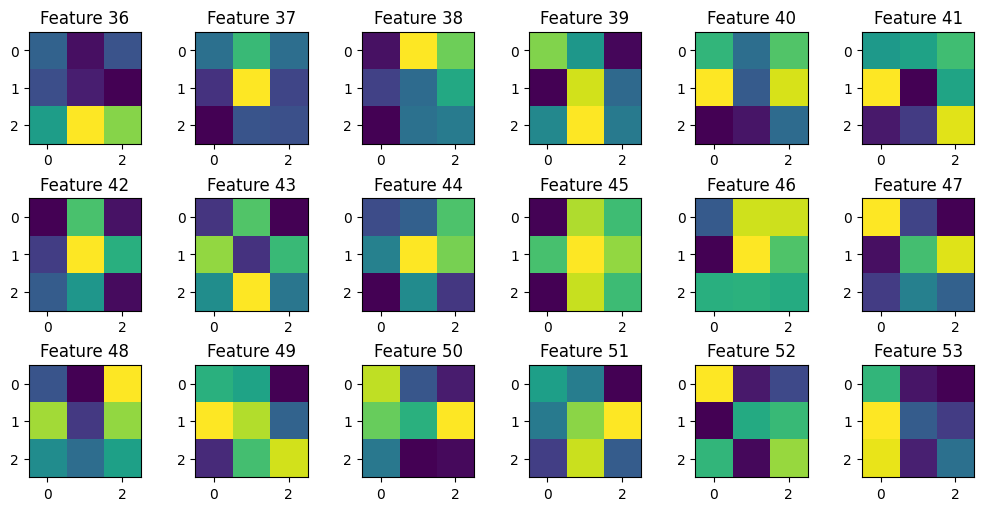

In [91]:
plot_features(2)

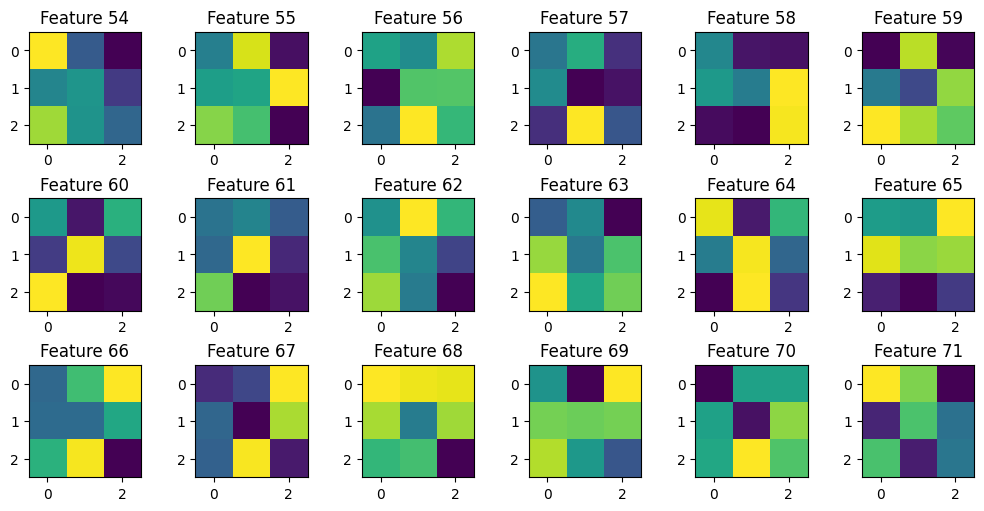

In [92]:
plot_features(3)

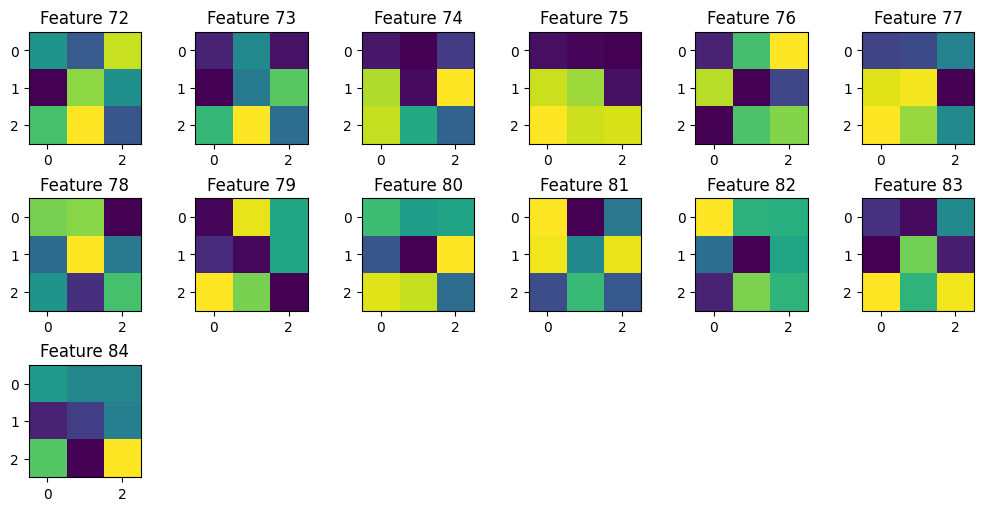

In [93]:
plot_features(4)

The concepts being learnt here seem fairly entangled, but we can try to interpret the meaning nonetheless.

The concept of the middle cell being alive can be somewhat seen in features 12, 30, 37, 44, 61 and 78.

Features 1 and 35 seem to show 3 living neighbours. Different permutations of 3 living neighbours along with the middle cell being alive seem to be present in features 4, 23, 31, 42 and 77.

2 living neighbours are shown by features 19, 28 and 47.

# Conclusion

In conclusion, feature visualization did not give much insight into how the model makes its predictions. This could be for multiple reasons.

It is possible that the model is learning human-comprehensible features in `conv0` like "middle cell alive" and exact configurations of "2 neighbours alive" and "3 neighbours" alive, but that these exist only as a linear combination of the neural network units rather than within a single unit.

To test this hypothesis, we could perform a linear regression to predict a meaningful concept such as "middle cell alive" from the `conv0` layer activations. If we can predict the concept with very high accuracy, it suggests that simple concepts exist in the network but are "between" the nodes rather than in any single node.

Another possibility is that the model is encoding the cell states into floating-point numbers in a "pathological" way. There are 512 possible combinations of states in a 3 x 3 grid, since each cell can only be alive or dead. This is 9 bits of information, which can easily be encoded into a single 32-bit floating-point number. In the worst case this means the entire state of the 3 x 3 grid could be encoded in a single 3 x 3 convolutional filter, provided later layers can extract this information. The feature visualization of the filter would be misleading.

To test this hypothesis, we could reduce number of filters in the `conv0` layer and see how few filters the model can have while still being able to train to 100% accuracy. We may need to increase the number of filters and/or layers after the `conv0` layer so the model can extract information from the `conv0` bottleneck.

> Incidentally, the reason I chose 85 as the number of filters in the `conv0` layer was because it was an intuitive lower bound for the number of filters needed to get 100% accuracy. The cell update rule depends on the cell's current state and whether the cell has 2 or 3 living neighbours. To identify whether the current cell is alive, a single convolutional filter will do: $ [[0, 0, 0], [0, 1, 0], [0, 0, 0]] $. To identify all the states where exactly 2 neighbours are alive, we use one filter for each state where 2 neighbours are alive, for example $ [[+1, +1, -1], [-1, 0, -1], [-1, -1, -1]] $ (or similar). This gives a total of $ {8 \choose 2} = 28 $ filters. Similarly, for the states where 3 neighbours are alive, we get $ {8 \choose 3} = 56 $ filters. In total, this gives $ 1 + 28 + 56 = 85 $ filters.
> 
> Thinking about it now, we could actually just count the number of alive neighbours with a single filter: $ [[1, 1, 1], [1, 0, 1], [1, 1, 1]] $. Thus, we would only need two filters at the `conv0` level, provided that later layers were able to perform the appropriate logic on those values to get the correct final result.

There are a number of approaches we could take to try and instill more interpretable concepts in the model.

Firstly, we could use regularization or dropout in the training process to make the model weights less complex.

Secondly, we could introduce noise into the training data so that the model does not rely on the input values being exactly 0 or 1.

Thirdly, we could try varying the model architecture. There is information online suggesting that deeper models are better able to disentangle concepts, however it is unclear whether this approach would be relevant to such a simple prediction task.